<a href="https://colab.research.google.com/github/atharvved09/examples-scikit-bio/blob/main/02-multi-omic-data/02-multi-omic-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 02: Working with various omic data types

- Author: Qiyun Zhu

---

[**Omics**](https://en.wikipedia.org/wiki/Omics) refer to the studies of the totality of biological entities within a system. They usually employ high-throughput techniques, such as DNA sequencing and mass spectrometry, to generate information about all molecules, genes, cells, organisms, and more. This information can be analyzed using bioinformatics methods to inform the structure, function and dynamics of the biological entities.

In microbiome research, because isolating and cultivating all microbes in a habitat is usually infeasible, omics are essential tools to characterize the microbiome (the name of which already indicates this nature). The prefix "**meta**-" is usually added to an omic to indicate the study of biological entities from all microorganisms within the environment (e.g., [metagenomics](https://en.wikipedia.org/wiki/Metagenomics)). Omics for microbiota can be employed in combination with omics for their host or the environment to profile a more comprehensive image of the biological system.

Depending on the biological molecules it studies, the most common omics for host and microbiota include:

- Molecule: DNA - mRNA - protein - metabolite
- (Host) ome: genome - transcriptome - proteome - metabolome
- (Microbiota) ome: metagenome - metatranscriptome - metaproteome - (meta)metabolome

In this section, we will use a real-world study -- the **Earth Microbiome Project 500** ([EMP500](https://earthmicrobiome.org/emp500/)), as an example to explore various omic data types. We will navigate the data tables and relevant data files associated with individual omics, discuss the unique challenges and solutions in working with omic data, and compare between omic data types. This process will support the analyses in all subsequent sections.

## Preparation

Install the latest version of scikit-bio if it hasn't been (needed for every Google Colab instance).

In [1]:
from importlib.util import find_spec

In [2]:
if find_spec('skbio') is None:
    !pip install -q scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.1 MB/s eta 0:00:00


In [3]:
import skbio
skbio.__version__

'0.7.1.post1'

Import common libraries.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Download the EMP500 dataset and unzip it. (If you have done it already, skip the following code.)

In [5]:
!wget -q -O emp500.tar.gz "https://www.dropbox.com/scl/fi/7sepykr3vhss60647osc8/emp500.tar.gz?rlkey=6q5ac48noeax5n2htaqslvo8g&dl=0"
!tar zxf emp500.tar.gz

In [6]:
HOME = 'emp500'

Check if the directory exists by listing its content.

In [7]:
!ls $HOME

amplicon  assembly  masspec  README.md	sample.tsv  shotgun


## The EMP500 study

A `README.md` file within the data directory provides basic information about the study. Take a quick look at it:

In [8]:
!head $HOME/README.md

# The EMP500 Dataset

The Earth Microbiome Project 500 (EMP500) was a multi-omic study of microbial
communities sampled from various biomes and habitats of the planet. The study
was published in:

- Shaffer, J. P., Nothias, L. F., Thompson, L. R., Sanders, J. G., Salido, R.
  A., Couvillion, S. P., ... & Knight, R. (2022). Standardized multi-omics of
  Earth’s microbiomes reveals microbial and metabolite diversity. Nature
  Microbiology, 7(12), 2128-2150.


The EMP500 project was described in the following paper:

- https://www.nature.com/articles/s41564-022-01266-x

In this work, the researchers performed multi-omic analyses of **880** samples collected from various free-living and host-associated environments across the Earth. They conducted amplicon sequencing (16S, 18S, ITS), shotgun metagenomics (and subsequent assembly), and untargeted metabolomics (LC-MS and GC-MS). Through the integration of these omic data types and sample traits, they identified the generic and environment-specific associations between microbes and metabolites.

![image.png](attachment:cc8e1e8a-f016-4856-8b46-097f6bea875c.png)

_**Fig. 1**: The 880 EMP500 samples: environmental classification and geographical locations. Linked from Fig. 1 of [Shaffer et al. (2022)](https://www.nature.com/articles/s41564-022-01266-x)._

## Sample metadata

[**Metadata**](https://en.wikipedia.org/wiki/Metadata) provides information about other data. In an omic study, the properties of the biological samples, specimens, subjects, etc. are usually provided by the **sample metadata**. Examples including demographics, morphology, behaviors, clinical measurements, etc. Sample metadata is the most essential component of an omic study, and should be treated in priority over any omic data. Without metadata, one is left with numbers but without any biological question to address.

- Meanwhile, there are **feature metadata** -- the information about biological entities studied in each omic. They will be discussed below.

### Metadata table

The sample metadata table, `sample.tsv`, is a tab-separated values ([TSV](https://en.wikipedia.org/wiki/Tab-separated_values)) file with samples as rows and properties as columns. Let's take a peek at the table:

In [9]:
!head $HOME/sample.tsv | cut -c1-100

sample_name	sample_name_original	sample_type	collection_timestamp	country	depth_sample	description	e
13114.angenent.65.s001	Angenent65.misc.104	bioreactor sludge	08/09/2011 0:00	USA - New York	not appl
13114.angenent.65.s002	Angenent65.misc.519	bioreactor sludge	9/27/12 0:00	USA - New York	not applica
13114.angenent.65.s003	Angenent65.misc.946	bioreactor sludge	11/28/13 0:00	USA - New York	not applic
13114.angenent.65.s004	Angenent65.misc.1022	bioreactor sludge	02/12/2014 0:00	USA - New York	not app
13114.angenent.65.s005	Angenent65.misc.1538	bioreactor sludge	7/13/15 0:00	USA - New York	not applic
13114.angenent.65.s006	Angenent65.misc.1622	bioreactor sludge	10/05/2015 0:00	USA - New York	not app
13114.angenent.65.s007	Angenent65.misc.1722	bioreactor sludge	1/13/15 0:00	USA - New York	not applic
13114.angenent.65.s008	Angenent65.misc.1818	bioreactor sludge	4/18/16 0:00	USA - New York	not applic
13114.angenent.65.s009	Angenent65.misc.1888	bioreactor sludge	6/27/16 0:00	USA - New York	n

This table can be loaded using Pandas, and scikit-bio fully supports the analysis of Pandas dataframes.

In [10]:
# meta = pd.read_table(f'{HOME}/sample.tsv', index_col=0)

Meanwhile, scikit-bio provides a specific class: [`SampleMetadata`](https://scikit.bio/docs/latest/generated/skbio.metadata.SampleMetadata.html), for handling sample metadata. This class was ported from [QIIME 2](https://qiime2.org/), a widely adopted platform for microbiome data analysis. If you are already familiar with QIIME 2, you may find this class familiar as well. Our team is working to expand its functionality beyond what was already offered.

In [11]:
from skbio.metadata import SampleMetadata

An advantage of `SampleMetadata` is that it implements pre-defined rules for parsing biological metadata. For example, [missing data](https://en.wikipedia.org/wiki/Missing_data) are prevalent in biological research. They can occur for multiple reasons, which should be noted rather than leaving the cells empty. The International Nucleotide Database Collaboration (INSDC, https://www.insdc.org/) defined terms representing different types of missing data, such as "not applicable", "not collected", "not provided" and "restricted access" (linked below).

- https://www.insdc.org/submitting-standards/missing-value-reporting/

In [12]:
meta = SampleMetadata.load(f'{HOME}/sample.tsv', default_missing_scheme='INSDC:missing')
meta

SampleMetadata
--------------
880 IDs x 33 columns
sample_name_original:          ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
sample_type:                   ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
collection_timestamp:          ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
country:                       ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
depth_sample:                  ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
description:                   ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
elevation:                     ColumnProperties(type='numeric', missing_scheme='INSDC:missing')
emp500_principal_investigator: ColumnProperties(type='categorical', missing_scheme='INSDC:missing')
emp500_study_id:               ColumnProperties(type='numeric', missing_scheme='INSDC:missing')
emp500_pi_study_id:            ColumnProperties(type='cat

A `SampleMetadata` object can be converted into a Pandas dataframe with:

In [13]:
df_ = meta.to_dataframe()
df_.head(3)

,sample_name_original,sample_type,collection_timestamp,country,depth_sample,description,elevation,emp500_principal_investigator,emp500_study_id,emp500_pi_study_id,...,env_feature,env_material,env_package,geo_loc_name,host_subject_id,host_scientific_name,latitude,longitude,project_name,scientific_name
sample_name,,,,,,,,,,,,,,,,,,,,,
13114.angenent.65.s001,Angenent65.misc.104,bioreactor sludge,08/09/2011 0:00,USA - New York,NaN,Corn Beer Fermentation Bioreactor Biomass,123.0,Angenent,65.0,Angenent65,...,anaerobic bioreactor,anaerobic sludge,host-associated,United States of America:State of New York:Cit...,LTA.misc.104,NaN,42.44,-76.5,Corn Beer Fermentation Bioreactor,bioreactor metagenome
13114.angenent.65.s002,Angenent65.misc.519,bioreactor sludge,9/27/12 0:00,USA - New York,NaN,Corn Beer Fermentation Bioreactor Biomass,123.0,Angenent,65.0,Angenent65,...,anaerobic bioreactor,anaerobic sludge,host-associated,United States of America:State of New York:Cit...,LTA.misc.519,NaN,42.44,-76.5,Corn Beer Fermentation Bioreactor,bioreactor metagenome
13114.angenent.65.s003,Angenent65.misc.946,bioreactor sludge,11/28/13 0:00,USA - New York,NaN,Corn Beer Fermentation Bioreactor Biomass,123.0,Angenent,65.0,Angenent65,...,anaerobic bioreactor,anaerobic sludge,host-associated,United States of America:State of New York:Cit...,LTA.misc.104,NaN,42.44,-76.5,Corn Beer Fermentation Bioreactor,bioreactor metagenome


### Metadata column

One can extract a metadata column by its name. The output is a [`MetadataColumn`](https://scikit.bio/docs/latest/generated/skbio.metadata.MetadataColumn.html) object.

For example, column `empo_2` describes the level 2 EMP Ontology ([EMPO](https://earthmicrobiome.org/protocols-and-standards/empo/)) of the environment from which the sample was collected.

In [14]:
empo_2 = meta.get_column('empo_2')
empo_2

<CategoricalMetadataColumn name='empo_2' id_count=880>

Likewise, a metadata column can be converted into a Pandas series.

In [15]:
s_ = empo_2.to_series()
s_

,empo_2
sample_name,
13114.angenent.65.s001,Animal
13114.angenent.65.s002,Animal
13114.angenent.65.s003,Animal
13114.angenent.65.s004,Animal
13114.angenent.65.s005,Animal
...,...
13114.zaneveld.9.s018,Animal
13114.zaneveld.9.s019,Animal
13114.zaneveld.9.s020,Animal


Using Pandas, one can further explore the distribution of values.

In [16]:
empo_2_freqs = s_.value_counts()
empo_2_freqs

,count
empo_2,
Non-saline,343
Animal,301
Plant,115
Saline,109
Fungus,12


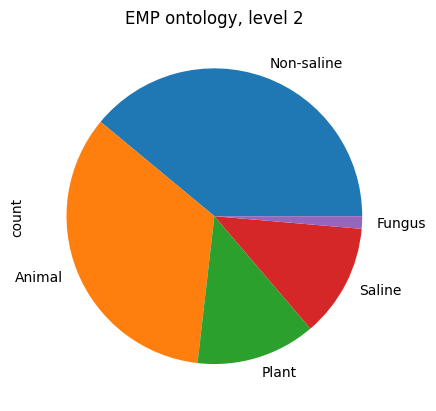

In [17]:
empo_2_freqs.plot.pie(title='EMP ontology, level 2');

## Amplicon sequencing

**[16S rRNA](https://en.wikipedia.org/wiki/16S_ribosomal_RNA) [amplicon](https://en.wikipedia.org/wiki/Amplicon) sequencing** is the classical approach for studying microbiomes. It usually involves high-throughput DNA sequencing of one or several variable regions of the 16S ribosomal RNA gene, which consitutes the backbone of the small subunit of the **prokaryotic** ribosome, and is universally present in all species. Since as early as 1977, researchers have been using 16S rRNA sequencing to identify unculturable microorganisms in the environment. Today, 16S rRNA sequencing remains an affordable, reliable and sensitive method for profiling the composition of microbial communities.

- The EMP500 study also generated **18S rRNA** (for eukaryotes) and internal transcribed spacer (**ITS**, for fungi) amplicon sequencing data. They are not included in this demo dataset, but are available from Qiita in case you want to further practice the skills.

The 16S rRNA data are provided under the `amplicon` directory.

In [18]:
!ls $HOME/amplicon

16s.biom  16s.fa  16s.nwk  16s.tax  16s.tsv  subset


### Sequences

The processed sequencing data are stored in `16s.fa`. This is a [FASTA](https://en.wikipedia.org/wiki/FASTA_format)-formatted file.

In [19]:
!head -n10 $HOME/amplicon/16s.fa

>00006499
AAACCAGCACCTCAAGTGGTCAGGAGGATTATTGGGCCTAAAGCATCCGTAGCCGGCTCTGTAAGTTTTCGGTTAAATCCATGTGCTCAACGCATGGGCTGCCGAAAATACTGCATAGCTAGGGAGTGGGAGAGGTAGACGGTACTCAGT
>00012890
AAAGTAGGAGACGAGCGTTATCCGGATTTACTGGGCGTAAAGCGTGTGCAGGCGGTTCGGCAAGTTGGATGTGAAATCTCCCGGCTCAACTGGGAGGGGTCGTTCAATACTACCAAACTTGAGGGCATCAGAGGAAGGTGGAATTCCGGG
>00012904
AAAGTAGGATCCGAGCGTTATCCGAATTTACTGGGCGTAAAGCGCGTGCAGGCGGTTCGGTAAGTTGGATGTGAAAGCTCCCGGCTCAACTGGGAGAGGTCGTTCAATACTGCCGGACTCGAGGATGGTAGAGGGAGGTGGAATTCCCGG
>00024522
AACAGAACCCCCAAGCGTTATCCGGATTTATTGGGCGTAAAGGGTCCGTAGGTGGTTAAGTTAGTCCAAAGTCAAATACTTCAGGCTCAACCTGAGGGACGCTTTGGAGACGGCTTAACTTGAGGGCATTAGGGGTTGATGGAACGGTCG
>00024634
AACAGAACCCGCAAGCATTATCCGGATTTATTGGGCGTAAAGGGTCCGTAGGTGGTCGGGAAAGTCTAAAGTCAAATACCTTGAGCTTAACTTAAGGGACGCTTTAGAAACTCCCTGACTTGAGGGCGTTAAAGGCTGATAGAACGGTCG


The method to work with sequence data in scikit-bio was introduced in section 01. For example, let's read the first sequence from the file:

In [20]:
from skbio import DNA

In [21]:
DNA.read(f'{HOME}/amplicon/16s.fa')

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '00006499'
Stats:
    length: 150
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 50.67%
---------------------------------------------------------------------
0   AAACCAGCAC CTCAAGTGGT CAGGAGGATT ATTGGGCCTA AAGCATCCGT AGCCGGCTCT
60  GTAAGTTTTC GGTTAAATCC ATGTGCTCAA CGCATGGGCT GCCGAAAATA CTGCATAGCT
120 AGGGAGTGGG AGAGGTAGAC GGTACTCAGT

Each sequence is 150 bp in length, which is limited by the sequencing platform (Illumina). It covers a portion of the 16S rRNA V4 region (appr. 252 bp), which has been shown effective and widely adopted in discerning microorganisms. The standard protocol for generating 16S rRNA V4 amplicons is provided at the [EMP website](https://earthmicrobiome.org/protocols-and-standards/16s/).

The raw sequencing data were processed by [Deblur](https://github.com/biocore/deblur) to extract amplicon sequence variants ([ASVs](https://en.wikipedia.org/wiki/Amplicon_sequence_variant)), which represent putatively unique microorganisms in the community. The ASV method provides finer resolution than the traditional operational taxonomic unit ([OTU](https://en.wikipedia.org/wiki/Operational_taxonomic_unit)) method.

The ASVs were then mapped against the **Greengenes 2** (GG2) reference database ([McDonald et al., 2024](https://www.nature.com/articles/s41587-023-01845-1)). The IDs of the ASVs correspond to IDs of reference sequences in the GG2 databases. You can access the database files at:

- https://ftp.microbio.me/greengenes_release/2022.10/

### Data table

The abundances (i.e., counts) of individual ASVs in indivdual samples are stored in a data table, as provided by the file `16s.biom`. The extension name `.biom` suggests that it is in the Biological Observation Matrix Format ([**BIOM**](https://biom-format.org/)), a computationally efficient format for storing omic data (we will explain why later).

scikit-bio has integrated BIOM in its [`Table`](https://scikit.bio/docs/latest/generated/skbio.table.Table.html) module. Therefore we can directly read a BIOM table.

In [22]:
from skbio import Table

In [23]:
table = Table.read(f'{HOME}/amplicon/16s.biom')
table

427269 x 805 <class 'biom.table.Table'> with 847146 nonzero entries (0% dense)

As shown, the dimensionality of this table is 427269 x 805 (you can also get this by `table.shape`). This means 805 samples and 427,269 observations (a.k.a., features).

The sample IDs are consistent with the sample IDs in the metadata.

In [24]:
table.ids('sample')[:10]

array(['13114.song.51.s009', '13114.minich.76.s006',
       '13114.stegen.38.s015', '13114.song.52.s002',
       '13114.mousseau.88.s056', '13114.mcmahon.21.s002',
       '13114.myrold.5.s008', '13114.song.51.s012', '13114.king.27.s017',
       '13114.stegen.36.s004'], dtype='<U48')

In [25]:
set(table.ids('sample')).issubset(meta.ids)

True

Not all sample IDs in the metadata (_n_ = 880) are found in this data table (_n_ = 805). This difference can be attributed to sample loss, insufficient biological materials, inadequate sequencing yield or quality, etc. This is common and one should be cautious about it, especially during multi-omic integration.

The observation IDs are units of microbial components in the community. As discussed above, each observation represents an ASV.

In [26]:
table.ids('observation')[:10]

array(['08665176', '13062664', '03483654', '21781706', '07176695',
       '18439252', '08434208', '07654326', '22343722', '13688331'],
      dtype='<U8')

In data science, a more generic term "[**feature**](https://en.wikipedia.org/wiki/Feature_(machine_learning)" is typically used to describe all independent variables, regardless of OTUs, ASVs, genes, metabolites, etc. A data table of samples by features like this one is usually referred to as a **feature table**.

### Sparse data

A BIOM table can be converted into a Pandas dataframe. This allows one to take a quick look at the table content. What did you see?

In [27]:
df = table.to_dataframe()
df.head()

,13114.song.51.s009,13114.minich.76.s006,13114.stegen.38.s015,13114.song.52.s002,13114.mousseau.88.s056,13114.mcmahon.21.s002,13114.myrold.5.s008,13114.song.51.s012,13114.king.27.s017,13114.stegen.36.s004,...,13114.thomas.19.s061,13114.angenent.65.s007,13114.mousseau.88.s011,13114.pinto.63.s025,13114.song.52.s005,13114.mousseau.88.s062,13114.roy.chowdhury.45.s010,13114.rohwer.85.s016,13114.jensen.43.s011,13114.Kshtrika1.misc.600
08665176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13062664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03483654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21781706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
07176695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Most cell values are zeros. This means that while there are more than 400k ASVs discovered across the sample collection, each sample only contains a very small subset of them. This indicates an important statistical property of biological omic data that is distinct from many other fields: [**sparsity**](https://en.wikipedia.org/wiki/Sparse_matrix).

One can let scikit-bio report the density (i.e., fraction of non-zero values) of the table:

In [28]:
table.get_table_density()

0.0024629806503703887

That is, only 0.25% of the cell values are non-zero.

In [29]:
sums = table.sum(axis='sample')
sums[:10]

array([3.6743e+04, 3.6377e+04, 1.5897e+04, 3.7726e+04, 4.1853e+04,
       4.8000e+01, 6.0000e+00, 3.2423e+04, 1.0679e+04, 2.1607e+04])

To efficiently store sparse data, one would avoid storing numerous zeros, but instead only store non-zero cell values and their coordinates. This is referred to as the [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). This is the underlying data structure of BIOM, as in contrast to the dense matrix as used in e.g. NumPy.

If needed, you can convert the BIOM table into a 2D NumPy array (a dense matrix). To avoid stressing the computer (because the data table is huge!), the following code only converts the first 5 rows and columns of the table.

In [30]:
table.head().matrix_data.toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

### Taxonomy

As shown above, there are over 400k features (ASVs) but merely ~800 samples in the 16S rRNA amplicon data table. Such a large number of features (referred to as [**high-dimensionality**](https://en.wikipedia.org/wiki/High-dimensional_statistics) in data science) imposes significant challenges to the subsequent analysis (you may read about the "[curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)" and intepretation. While there are pure mathematical approaches to mitigate high-dimensionality, biological sciences provide unique, knowledge-based solutions to it.

These features are not a plain list of entities. They are (presumably) microorganisms, and organisms can be classified. The classification of organisms, a.k.a., [**taxonomy**](https://en.wikipedia.org/wiki/Taxonomy), provides a hierarchical system with (usually) some 7-8 fixed ranks to describe the relationships among organisms.

The taxonomic assignments of the ASVs according to the GG2 reference is provided in the file `16s.tax`. It reads like:

In [31]:
!head $HOME/amplicon/16s.tax

00006499	d__Archaea; p__Thermoproteota; c__Nitrososphaeria_A; o__Nitrososphaerales; f__Nitrosopumilaceae; g__Nitrosopelagicus; s__Nitrosopelagicus sp000402075
00012890	d__Bacteria; p__Chloroflexota; c__Anaerolineae; o__Anaerolineales; f__EnvOPS12; g__UBA8950; s__UBA8950 sp001872455
00012904	d__Bacteria; p__Chloroflexota; c__Anaerolineae; o__Anaerolineales; f__; g__; s__
00024522	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__Paceibacterales; f__; g__; s__
00024634	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__Paceibacterales; f__; g__; s__
00024664	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__Paceibacterales; f__UBA5738; g__UBA5738; s__UBA5738 sp002423555
00024725	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__Paceibacterales; f__UBA5738; g__UBA5738; s__UBA5738 sp002423555
00024797	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__Paceibacterales; f__UBA10102; g__; s__
00025031	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__Paceibacterales; f__

It is a mapping of ASV IDs to taxonomic **lineage** strings. Each lineage string consists of [seven ranks](https://en.wikipedia.org/wiki/Taxonomic_rank), as indicated by their initials. The seven ranks are (from high to low):

In [32]:
ranks = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

The following code can read lineage strings into a Pandas dataframe with columns representing individual ranks.

In [33]:
taxonomy = {}
with open(f'{HOME}/amplicon/16s.tax', 'r') as f:
    for line in f:
        id_, lineage = line.rstrip().split('\t')
        ranked = [x.split('__')[1] for x in lineage.split('; ')]
        taxonomy[id_] = ranked
taxonomy = pd.DataFrame.from_dict(taxonomy, orient='index', columns=ranks).replace('', np.nan)
taxonomy.head()

,Domain,Phylum,Class,Order,Family,Genus,Species
00006499,Archaea,Thermoproteota,Nitrososphaeria_A,Nitrososphaerales,Nitrosopumilaceae,Nitrosopelagicus,Nitrosopelagicus sp000402075
00012890,Bacteria,Chloroflexota,Anaerolineae,Anaerolineales,EnvOPS12,UBA8950,UBA8950 sp001872455
00012904,Bacteria,Chloroflexota,Anaerolineae,Anaerolineales,NaN,NaN,NaN
00024522,Bacteria,Patescibacteria,Paceibacteria,Paceibacterales,NaN,NaN,NaN
00024634,Bacteria,Patescibacteria,Paceibacteria,Paceibacterales,NaN,NaN,NaN


Given the taxonomy, one can collapse the data table to a specific taxonomic rank. The collapsing process will aggregate (sum) cell values that belong to the same taxonomic group. This not only facilitates biologically meaningful description of community composition, but also serves as a knowledge-guided method of dimensionality reduction. The following example converts the features into the phylum level.

In [34]:
table_phylum = table.collapse(taxonomy['Phylum'].to_dict(), norm=False, axis='observation')
table_phylum

124 x 805 <class 'biom.table.Table'> with 19786 nonzero entries (19% dense)

After collapsing, the data table becomes:

In [35]:
table_phylum.to_dataframe().head()

,13114.song.51.s009,13114.minich.76.s006,13114.stegen.38.s015,13114.song.52.s002,13114.mousseau.88.s056,13114.mcmahon.21.s002,13114.myrold.5.s008,13114.song.51.s012,13114.king.27.s017,13114.stegen.36.s004,...,13114.thomas.19.s061,13114.angenent.65.s007,13114.mousseau.88.s011,13114.pinto.63.s025,13114.song.52.s005,13114.mousseau.88.s062,13114.roy.chowdhury.45.s010,13114.rohwer.85.s016,13114.jensen.43.s011,13114.Kshtrika1.misc.600
Proteobacteria,916.0,12636.0,4400.0,32.0,2126.0,6.0,0,206.0,1079.0,4302.0,...,8162.0,1014.0,6954.0,26091.0,30.0,139.0,2.0,15152.0,5473.0,0
Desulfobacterota_C,0,0,0,0,0,0,0,0,0,21.0,...,0,0,0,0,0,0,0,0,90.0,0
Planctomycetota,0,315.0,1292.0,5802.0,0,0,2.0,0,0,721.0,...,179.0,24.0,230.0,730.0,99.0,12.0,0,0,2679.0,0
Thermoplasmatota,0,0,0,0,0,0,0,0,0,2.0,...,0,0,8.0,0,0,0,0,0,31.0,0
Gemmatimonadota,0,0,2.0,0,0,0,0,0,0,1038.0,...,0,0,15.0,364.0,0,0,0,0,177.0,0


Note: If you work with a Pandas dataframe instead of a BIOM table, you can achieve this using the `groupby` function.

In [36]:
# table.to_dataframe().groupby(taxonomy['Phylum']).sum()

It should be noted that 16S rRNA sequencing, particularly V4 region sequencing, can reach a taxonomic resolution as low as **genus**. Despite that the taxonomic assignment also contains species, it is usually considered less reliable to base the analysis on a species-level profile inferred from 16S rRNA data.

However, the emerging technique of **full-length rRNA operon sequencing** largely overcomes this limitation by targetting the entire 16S rRNA gene (about 1.5 kb) or even the entire rRNA operon (about 4.5 kb) with the [long-read sequencing technology](https://en.wikipedia.org/wiki/Third-generation_sequencing). The EMP500 study also generated full-length rRNA operon data, despite not included in this demo dataset. You may consider exploring it as a practice after the tutorial.

## Shotgun metagenomics

[**Shotgun sequencing**](https://en.wikipedia.org/wiki/Shotgun_sequencing) randomly sequences all DNA fragments in a biological sample, rather than targeting a specific DNA region as amplicon sequencing does. [Shotgun metagenomics](https://en.wikipedia.org/wiki/Shotgun_sequencing#Metagenomic_shotgun_sequencing), or whole-metagenomic shotgun (WMS) sequencing, or simply "[metagenomics](https://en.wikipedia.org/wiki/Metagenomics)", is the application of shotgun sequencing to recover DNA sequences from all microorganisms in a habitat.

Compared with 16S rRNA sequencing, shotgun metagenomics delivers higher resolution (usually down to species- or even strain-level), informs function in addition to composition, and includes all domains of life (including viruses and eukaryotes) rather than just prokaryotes, despite being more expensive, and more challenging in bioinformatic analysis.

There are two strategies to analyze shotgun metagenomic data:

1) **Read-based**, which usually involves mapping sequencing reads against a reference database to inform the composition of a metagenome.
2) **Assembly-based**, which performs assembly of sequencing reads to recover the original microbial genomes in a (usually) reference-free way.

The shotgun metagenomic data processed using the read-based method is provided within the `shotgun` directory.

In [37]:
!ls $HOME/shotgun

ec.biom  ko.name   ogu.info  ogu.tax	   pathway.name
ko.biom  ogu.biom  ogu.nwk   pathway.biom


The basic data table is `ogu.biom`. This table was generated by aligning sequencing reads against the Web of Life 2 (**WoL2**) reference genome database ([Zhu et al., 2019](https://www.nature.com/articles/s41467-019-13443-4)), and quantifying the number of reads mapped to each reference genome. The database files are available at:

- https://ftp.microbio.me/pub/wol2/

Read the BIOM table. It contains 801 samples and 14,933 features.

In [38]:
table = Table.read(f'{HOME}/shotgun/ogu.biom')
table

14933 x 801 <class 'biom.table.Table'> with 1344863 nonzero entries (11% dense)

Each feature represents a reference genome. They are referred to as the operational genomic units (**OGUs**) ([Zhu et al., 2022](https://journals.asm.org/doi/full/10.1128/msystems.00167-22)), a term indicating that they are not the exact genomes that are present in the sample, but are reference genomes to which sequencing data can be mapped to. The true members of the microbial community may be closely related to those reference strains.

In [39]:
table.ids('observation')[:10]

array(['G000005825', 'G000006175', 'G000006605', 'G000006725',
       'G000006745', 'G000006785', 'G000006845', 'G000006865',
       'G000006925', 'G000006965'], dtype='<U10')

The information of the OGUs is provided in `ogu.info`.

In [40]:
!head $HOME/shotgun/ogu.info | cut -c1-100

#genome	assembly_accession	bioproject	biosample	wgs_master	refseq_category	taxid	species_taxid	organ
G000005825	GCF_000005825.2	PRJNA224116	SAMN02603086		representative genome	398511	79885	Bacillus pse
G000006175	GCF_000006175.1	PRJNA224116	SAMN00000040		representative genome	456320	2188	Methanococcus
G000006605	GCF_000006605.1	PRJNA224116	SAMEA3283089		representative genome	306537	38289	Corynebacter
G000006725	GCF_000006725.1	PRJNA224116	SAMN02603773		representative genome	160492	2371	Xylella fasti
G000006745	GCF_000006745.1	PRJNA224116	SAMN02603969		na	243277	666	Vibrio cholerae O1 biovar El Tor 
G000006785	GCF_000006785.2	PRJNA224116	SAMN02604089		na	160490	1314	Streptococcus pyogenes M1 GAS	st
G000006845	GCF_000006845.1	PRJNA224116	SAMN02604088		na	242231	485	Neisseria gonorrhoeae FA 1090	str
G000006865	GCF_000006865.1	PRJNA224116	SAMN02603339		na	272623	1358	Lactococcus lactis subsp. lactis
G000006925	GCF_000006925.2	PRJNA62907	SAMN02603599		reference genome	198214	623	Shigella fl

Like the 16S rRNA data, the OGU table is also sparse (11% of the cell values are non-zero). An additional challenge in read-based metagenomics is that false positive assignments are prevalent. Therefore, the researcher needs to be scrutious.

In [41]:
table.get_table_density()

0.11243420779272678

The taxonomic assignments of the OGUs are provided in `ogu.tax`.

In [42]:
taxonomy = {}
with open(f'{HOME}/shotgun/ogu.tax', 'r') as f:
    for line in f:
        id_, lineage = line.rstrip().split('\t')
        ranked = [x.split('__')[1] for x in lineage.split('; ')]
        taxonomy[id_] = ranked
taxonomy = pd.DataFrame.from_dict(taxonomy, orient='index', columns=ranks).replace('', np.nan)
taxonomy.head()

,Domain,Phylum,Class,Order,Family,Genus,Species
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales_H,Bacillaceae_D,Bacillus_S,Bacillus_S pseudofirmus
G000006175,Archaea,Methanobacteriota_A,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,Methanococcus voltae_A
G000006605,Bacteria,Actinobacteriota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Corynebacterium,Corynebacterium jeikeium
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,Xylella fastidiosa
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,Vibrio cholerae


### Phylogeny

As a classification method, taxonomy is descriptive, operational but coarse. The 7-8 standard taxonomic ranks may fall short in resolving the ever increasing number of discovered organisms (there are now more than 2 million microbial genomes in NCBI). To capture the relationships among microbes with finer resolution, one may resort to phylogeny instead.

A [**phylogenetic tree**](https://en.wikipedia.org/wiki/Phylogenetic_tree) is a graph that describes the evolutionary relationships among organisms. All (cellular) organisms descend from a common ancestor. Therefore a tree structure from a root to many tips can unite them all. The phylogenetic tree not only contains the branching pattern (**topology**) indicating the order of speciation, but also provides **branch lengths** indicating the amount of evolution accumulated within each lineage. Therefore, phylogeny is suitable for modeling microbial feature relations in a quantitative manner.

The WoL2 reference phylogeny is provided by `ogu.nwk`. It is a [Newick](https://en.wikipedia.org/wiki/Newick_format)-formatted file. One can read it using scikit-bio's [`TreeNode`](https://scikit.bio/docs/latest/generated/skbio.tree.TreeNode.html) class.

In [43]:
from skbio import TreeNode

In [44]:
tree = TreeNode.read(f'{HOME}/shotgun/ogu.nwk')
tree

<TreeNode, name: N1, internal node count: 15245, tips count: 15953>

Because the tree is large, we cannot display the entirety of it. But let's locate an arbitrary tip (the first OGU in the list, `G000005825`), trace up to its grandparent, and display a very small clade descending from it.

In [45]:
print(tree.find('G000005825').parent.parent.ascii_art())

                    /-G000005825
          /N8376---|
         |         |          /-G000513115
         |          \N8873---|
         |                   |          /-G000513095
-N7879---|                    \N9376---|
         |                              \-G000513135
         |
         |          /-G001310555
          \N8377---|
                   |          /-G001590785
                    \N8874---|
                             |          /-G000292245
                              \N9377---|
                                        \-G001038565


This structure enables a series of analyses, which will be discussed in later sections.

Note: The 16S rRNA data also comes with a reference phylogeny: `16s.nwk` under the `amplicon` directory. We skipped it because it will be discussed in a later section.

### Function

One major advantage of shotgun metagenomics over amplicon sequencing is that it provides information of whole microbial genomes. Therefore, one can identify the functional genes present in those genomes, and subsequently predict the [**biological function**](https://en.wikipedia.org/wiki/Function_(biology)) of the metagenome.

The WoL2 database and the [Woltka](https://github.com/qiyunzhu/woltka/) program enabled identification of genes from read-to-genome alignments, and collapsing the results according to a variety of functional ontologies. In the demo dataset, results were collapsed according to the [KEGG](https://www.genome.jp/kegg/) ontology.

`ko.biom` records the number of reads per sample that can be assigned to each KEGG ortholog (KO).

In [46]:
table = Table.read(f'{HOME}/shotgun/ko.biom')
table

9319 x 799 <class 'biom.table.Table'> with 1674550 nonzero entries (22% dense)

In [47]:
table.ids('observation')[:10]

array(['K00001', 'K00003', 'K00004', 'K00005', 'K00007', 'K00008',
       'K00009', 'K00010', 'K00012', 'K00013'], dtype='<U6')

The description of each KO is provided in `ko.name`.

In [48]:
!head -n5 $HOME/shotgun/ko.name

K00001	E1.1.1.1, adh; alcohol dehydrogenase [EC:1.1.1.1]
K00003	hom; homoserine dehydrogenase [EC:1.1.1.3]
K00004	BDH, butB; (R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]
K00005	gldA; glycerol dehydrogenase [EC:1.1.1.6]
K00007	dalD; D-arabinitol 4-dehydrogenase [EC:1.1.1.11]


The KOs were grouped by their [Enzyme Commission (EC) numbers](https://enzyme.expasy.org/), as provided in `ec.biom`.

In [49]:
table = Table.read(f'{HOME}/shotgun/ec.biom')
table

3326 x 797 <class 'biom.table.Table'> with 784055 nonzero entries (29% dense)

In [50]:
table.ids('observation')[:10]

array(['1.-.-.-', '1.1.-.-', '1.1.1.-', '1.1.1.1', '1.1.1.10',
       '1.1.1.100', '1.1.1.102', '1.1.1.103', '1.1.1.107', '1.1.1.108'],
      dtype='<U11')

The KOs were collapsed by the metabolic pathways they participate, as provided in `pathway.biom`.

In [51]:
table = Table.read(f'{HOME}/shotgun/pathway.biom')
table

110 x 787 <class 'biom.table.Table'> with 59624 nonzero entries (68% dense)

In [52]:
table.ids('observation')[:10]

array(['ko00010', 'ko00020', 'ko00030', 'ko00040', 'ko00051', 'ko00052',
       'ko00053', 'ko00061', 'ko00062', 'ko00071'], dtype='<U7')

The description of each pathway is provided in `pathway.name`.

In [53]:
!head -n5 $HOME/shotgun/pathway.name

ko00010	Glycolysis / Gluconeogenesis
ko00020	Citrate cycle (TCA cycle)
ko00030	Pentose phosphate pathway
ko00040	Pentose and glucuronate interconversions
ko00051	Fructose and mannose metabolism


Shotgun metagenomics captures a static image of microbiome function -- the presence of functional genes in microbial genomes. However, it falls short in informing the expression of those genes. A complementary technique -- [**metatranscriptomics**](https://en.wikipedia.org/wiki/Metatranscriptomics), quantifies the mRNAs (transcripts) of a biological sample, thereby providing such information. This method has seen increasing popularity in microbiome research.

## Metagenomic assembly

Shotgun metagenomic sequencing data can be bioinformatically [**assembed**](https://en.wikipedia.org/wiki/Sequence_assembly) into longer sequences (contigs or scaffolds), and [**binned**](https://en.wikipedia.org/wiki/Binning_(metagenomics)) into putative draft genomes, a.k.a., metagenome-assembled genomes (**MAGs**). This process allows researchers to directly characterize microbes present in a sample, rather than relying on a reference as a proxy.

Assembly-based metagenomics provides more compelling evidence and more comprehensive view of individual microbes, as compared with read-based metagenomics. However, assembly and binning are bioinformatically challenging (i.e., MAGs may not be perfectly recovered), and less sensitive with low-abundance microbes. Therefore both strategies are complementary to each other in a metagenomic study.

The results of metagenomic assembly are provided under the `assembly` directory.

In [54]:
!ls $HOME/assembly

fasta  mag.biom  mag.tax  prokka


A total of **811** high-quality MAGs were recovered from the EMP500 samples. Their sequences (scaffolds of individual bins) are provided under `assembly/fasta`.

In [55]:
!basename -a $HOME/assembly/fasta/*.fa | head -n5

Bioreactor.Metabat.Bin.10.fa
Bioreactor.Metabat.Bin.11.fa
Bioreactor.Metabat.Bin.14.fa
Bioreactor.Metabat.Bin.16.fa
Bioreactor.Metabat.Bin.19.fa


In [56]:
!head -n5 $HOME/assembly/fasta/Bioreactor.Metabat.Bin.10.fa

>NODE_8_length_861446_cov_17.890671
CGTTTTGTTTAATTTCCAAATTAAATTGAAATTTTTTTCGTTTAGATTATGTAAATAACT
GATAATAAGATGGAAAAATTTCACTAATTATTATAAAGTAAATTCTAAAAATATTTACGA
ATGTTTTCTATAGCCCCGATTGTAAAGGAAATCCTTTTTTGCGAGATGGCTTGCCGAGCA
AAAAAGATTGTAGTGGAAAGCGGGAAATAGCTTCTAATTTTCTTTATAAATATTGATTAA


The abundance of each MAG in each sample was quantifying by aligning sequencing reads back to MAG sequences. The results are provided in `mag.biom`.

In [57]:
table = Table.read(f'{HOME}/assembly/mag.biom')
table

811 x 813 <class 'biom.table.Table'> with 249292 nonzero entries (37% dense)

In [58]:
table.ids('observation')[:10]

array(['SW.Metabat.Bin.241.fa', 'Song_Terr.Metabat.Bin.486.fa',
       'Song_Terr.Metabat.Bin.574.fa', 'Song_Terr.Metabat.Bin.455.fa',
       'Song_Terr.Metabat.Bin.534.fa', 'Song_Terr.Metabat.Bin.529.fa',
       'Myrold59_soil.Metabat.Bin.1.fa', 'SaltMarsh.Metabat.Bin.33.fa',
       'Bird_feces.Metabat.Bin.58.fa', 'Myrold59_soil.Metabat.Bin.7.fa'],
      dtype='<U35')

The MAGs were classified using [GTDB-Tk](https://github.com/Ecogenomics/GTDBTk). The results are provided in `mag.tax`.

In [59]:
!head -n5 $HOME/assembly/mag.tax

Bioreactor.Metabat.Bin.10	d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Weeksellaceae; g__Cloacibacterium; s__
Bioreactor.Metabat.Bin.11	d__Bacteria; p__Patescibacteria; c__Paceibacteria; o__UBA9973; f__UBA918; g__OLB19; s__
Bioreactor.Metabat.Bin.14	d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Chitinophagaceae; g__UTBCD1; s__UTBCD1 sp002066995
Bioreactor.Metabat.Bin.16	d__Bacteria; p__Bacteroidota; c__Ignavibacteria; o__SJA-28; f__B-1AR; g__OLB4; s__OLB4 sp002050165
Bioreactor.Metabat.Bin.19	d__Bacteria; p__Pseudomonadota; c__Alphaproteobacteria; o__Caulobacterales; f__Caulobacteraceae; g__Brevundimonas; s__


### Annotation

Each MAG was [**annotated**](https://en.wikipedia.org/wiki/DNA_annotation) using [Prokka](https://github.com/tseemann/prokka). This process identifies functional features, such as protein-coding genes, tRNAs, rRNAs and more, on each genome. The outputs are provided under `assembly/prokka`. Specifically, there are protein sequences (`faa`), their corresponding coding sequences (CDSes) (`ffn`) and the annotation tables (`gff`).

In [60]:
!ls $HOME/assembly/prokka

faa  ffn  gff  stats.tsv


The predicted protein sequences and their descriptions are like:

In [61]:
!zcat < $HOME/assembly/prokka/faa/Bioreactor.Metabat.Bin.10.faa.gz | head

/bin/bash: line 1: emp500/assembly/prokka/faa/Bioreactor.Metabat.Bin.10.faa.gz: No such file or directory


Each [**GFF3**](https://en.wikipedia.org/wiki/General_feature_format)-formatted annotation table records the start and end coordinates of each feature and their descriptions. scikit-bio's [`IntervalMetadata`](https://scikit.bio/docs/latest/generated/skbio.metadata.IntervalMetadata.html) class can process such data.

In [62]:
from skbio.metadata import IntervalMetadata

Let's read the annotation of the first scaffold sequence of a MAG.

In [63]:
fp = f'{HOME}/assembly/prokka/gff/Bioreactor.Metabat.Bin.10.gff'

In [64]:
anno = IntervalMetadata.read(fp, seq_id='NODE_8_length_861446_cov_17.890671')
anno

840 interval features
---------------------
Interval(interval_metadata=<136076787586720>, bounds=[(213, 885)], fuzzy=[(False, False)], metadata={'source': 'Prodigal:002006', 'type': 'CDS', 'score': '.', 'strand': '-', 'phase': 0, 'ID': 'GHKEOJEL_00001', 'inference': 'ab initio prediction:Prodigal:002006', 'locus_tag': 'GHKEOJEL_00001', 'product': 'hypothetical protein'})
Interval(interval_metadata=<136076787586720>, bounds=[(896, 1751)], fuzzy=[(False, False)], metadata={'source': 'Prodigal:002006', 'type': 'CDS', 'score': '.', 'strand': '-', 'phase': 0, 'ID': 'GHKEOJEL_00002', 'eC_number': '1.1.1.133', 'Name': 'rmlD', 'gene': 'rmlD', 'inference': 'ab initio prediction:Prodigal:002006,similar to AA sequence:UniProtKB:O66251', 'locus_tag': 'GHKEOJEL_00002', 'product': 'dTDP-4-dehydrorhamnose reductase'})
...
Interval(interval_metadata=<136076787586720>, bounds=[(860451, 860829)], fuzzy=[(False, False)], metadata={'source': 'Prodigal:002006', 'type': 'CDS', 'score': '.', 'strand': '+', '

## Untargeted metabolomics

The chemistry of a biological sample can be assessed by [mass spectrometry](https://en.wikipedia.org/wiki/Mass_spectrometry) (**MS**), a technique that breaks molecules into ions and quantifies the mass-to-charge ratio of ions. The information can be analyzed bioinformatically to recover the chemical profile of the sample.

[**Metabolomics**](https://en.wikipedia.org/wiki/Metabolomics) refers to the analysis of _small molecules_ (usually <1.5 kDa) in a sample. These molecules are usually (but not always) metabolites involved in a biological system. Therefore, metabolomics describes the causations and consequences of biological functions. Metabolomics is usually achieved through MS. The term "metabolomics" seemingly indicates microbiome ("meta-)", but in fact it covers all small molecules, microbe- or host-related, or ones related to both, a sample.

- The analysis of _large molecules_, typically proteins, is referred to as [proteomics](https://en.wikipedia.org/wiki/Proteomics) (or [**metaproteomics**](https://en.wikipedia.org/wiki/Metaproteomics) when it concerns microbiomes). It is also (usually) achieved using MS, however with different target molecular weight range. It is useful for analyzing the translation of microbial genes (in addition to transcription, as metatranscriptomics does).

Just like amplicon and shotgun sequencing methods, metabolomics can be categorize into targetted and **untargeted**, the latter captures any molecule (without a specific target) in a biological system.

The mass spectrometry data are provided under the `masspec` directory.

In [65]:
!ls $HOME/masspec

canopus.tsv  fbmn.tsv  is.microbial  lcms.biom


The file `lcms.biom` is a data table derived from the liquid chromatography-tandem mass spectrometry ([**LC-MS/MS**](https://en.wikipedia.org/wiki/Liquid_chromatography%E2%80%93mass_spectrometry)). The spectrum data were processed using [MZmine](https://mzmine.github.io/download.html). Each cell value represents the ion intensity (i.e., peak area) of a spectrum.

- Complementarily, the EMP500 team performed gas chromatography–mass spectrometry ([**GC–MS**](https://en.wikipedia.org/wiki/Gas_chromatography%E2%80%93mass_spectrometry)), a technique suitable for identifying substances with high volatility (whereas LC-MS is broad-spectrum). The GC-MS data is not included in the demo dataset, but you can try to find and analyze it for practice.

In [66]:
table = Table.read(f'{HOME}/masspec/lcms.biom')
table

52496 x 618 <class 'biom.table.Table'> with 13252433 nonzero entries (40% dense)

Unlike DNA sequencing data, the cell values are not integers.

In [67]:
table.to_dataframe().head()

,13114.mayer.34.s008,13114.king.27.s003,13114.metcalf.40.s014,13114.berry.2.s009,13114.mayer.34.s006,13114.berry.2.s016,13114.mayer.34.s004,13114.berry.2.s013,13114.mayer.34.s005,13114.metcalf.40.s011,...,13114.pinto.62.s012,13114.pinto.62.s013,13114.pinto.62.s014,13114.pinto.62.s015,13114.pinto.62.s016,13114.pinto.62.s020,13114.pinto.62.s021,13114.pinto.62.s022,13114.pinto.62.s023,13114.pinto.62.s024
48,708502.552009,742278.375775,780958.569711,525207.300634,837844.689714,1053890.955027,2277550.765829,552157.680682,1179237.016635,2748297.819676,...,47982.975828,19442.191001,12980.440753,119126.009914,118102.826454,776581.281141,50417.260057,49672.51069,14376.599412,16604.140035
66,756467.905517,181889.791978,113203.48584,75658.911859,70067.723199,112611.885491,594923.758322,174490.808163,195012.211269,2008954.672368,...,20829.936317,16638.240278,30219.774487,23545.752273,14887.642869,95195.165107,8013.130592,13010.343786,13802.244664,16931.318684
72,1032820.099247,481232.796289,1552998.498345,0,614104.200347,117087.877593,547994.579832,1381665.580329,222175.789584,518249.531565,...,894220.947705,671855.752303,0,137499.18635,188622.31547,649648.468435,394061.155994,142007.36747,45646.719534,0
74,156171.224081,54795.567999,0,51718.926669,58285.43987,79254.90734,173580.544466,623636.91613,248736.367788,0,...,43242.9141,0,45532.972947,60441.97725,0,0,42873.470147,63038.621463,0,0
78,0,114801.646948,862922.71701,0,619526.558313,154669.075313,66938.299592,0,902987.716157,0,...,0,125630.772463,411793.312374,0,150690.051884,64049.512684,105533.343132,0,114020.088281,81276.930523


The spectrum data were subject to the feature-based molecular networking workflow ([**FBMN**](https://lfnothias.github.io/GNPSDocumentation/featurebasedmolecularnetworking/)) implemented on the [GNPS](https://gnps.ucsd.edu/ProteoSAFe/static/gnps-splash.jsp) server ([Wang et al., 2016](https://www.nature.com/articles/nbt.3597)) in order to group and identify them and to identify their source molecules. The latter task was achieve by searching reference databases (just like with sequence data).

In [68]:
fbmn = pd.read_table(f'{HOME}/masspec/fbmn.tsv', index_col=0)
fbmn.head()

,mqscore,spectrum,library,smiles,inchi
id,,,,,
48,0.905755,CCMSLIB00003303197,"2,6-Di-tert-butyl-4-hydroxymethylphenol",CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CO,"InChI=1S/C15H24O2/c1-14(2,3)11-7-10(9-16)8-12(..."
66,0.953557,CCMSLIB00003303202,"2,6-Di-tert-butyl-4-hydroxymethylphenol",CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CO,"InChI=1S/C15H24O2/c1-14(2,3)11-7-10(9-16)8-12(..."
72,0.811642,CCMSLIB00005761025,Massbank:LU030804 Lauryldiethanolamine|2-[dode...,CCCCCCCCCCCCN(CCO)CCO,1S/C16H35NO2/c1-2-3-4-5-6-7-8-9-10-11-12-17(13...
74,0.761311,CCMSLIB00005761025,Massbank:LU030804 Lauryldiethanolamine|2-[dode...,CCCCCCCCCCCCN(CCO)CCO,1S/C16H35NO2/c1-2-3-4-5-6-7-8-9-10-11-12-17(13...
78,0.706896,CCMSLIB00005764095,Massbank:LU030803 Lauryldiethanolamine|2-[dode...,CCCCCCCCCCCCN(CCO)CCO,1S/C16H35NO2/c1-2-3-4-5-6-7-8-9-10-11-12-17(13...


Among a total of 52,496 spectra, only 6,513 (12%) were annotated. This implicates the challenges of analyzing mass spectrum data.

In [69]:
fbmn.shape[0]

52496

In [70]:
fbmn.dropna(how='all').shape[0]

6513

In parallel, the data were analyzed using **CANOPUS**, a deep neural network framework for classifying molecules ([Dührkop et al., 2021](https://www.nature.com/articles/s41587-020-0740-8)). The classification follows the hierarchy of formula - class - superclass - pathway (just like taxonomy).

In [71]:
canopus = pd.read_table(f'{HOME}/masspec/canopus.tsv', index_col=0)
canopus.head()

,formula,class,superclass,pathway
id,,,,
48,C15H22O,NaN,Sesquiterpenoids,Terpenoids
66,C15H22O,NaN,Sesquiterpenoids,Terpenoids
72,C16H35NO2,Fatty alcohols,Fatty acyls,Fatty acids
74,C16H35NO2,Straight chain fatty acids,Fatty Acids and Conjugates,Fatty acids
78,C16H35NO2,Straight chain fatty acids,Fatty Acids and Conjugates,Fatty acids


A much larges number (43,072, or 82%) of spectra were classified.

In [72]:
canopus.dropna(how='all').shape[0]

43072

Among the 52.5k spectra recovered from the samples, only a small proportion can be related to microbes. The EMP500 team ensembled annotation results by multiple workflows, and obtained a consensus list of microbially related secondary metabolites. The results (0 - no, 1 - yes) are provided in `is.microbial`. This file indicates that 6588 (12.5%) spectra are microbial.

In [73]:
!head -n5 $HOME/masspec/is.microbial

48	0
66	0
72	0
74	0
78	0


In [74]:
pd.read_table(f'{HOME}/masspec/is.microbial', index_col=0, names=['Microbial']).squeeze().astype(bool).value_counts()

,count
Microbial,
False,45908
True,6588


## Summary

This section navigated the components of EMP500, a multi-omic dataset: sample metadata, data tables, and feature metadata (taxonomy, phylogeny, functional ontology, etc.). It discussed the various omic data types included in this demo dataset and beyond. It demonstrated how to use scikit-bio and other Python libraries to parse and explore these files. We will perform analysis of these data using scikit-bio in the following sections.